In [1]:
# Importer
import classes.utils as utils
from classes.splitter import Splitter
from classes.classifier_trainer import ClassifierTrainer
from classes.drift_detector import DriftDetector
from classes.mlflow_manager import MLflowManager

from sklearn.tree import DecisionTreeClassifier

import numpy as np

utils.set_parent_directory_as_working_directory()

# TODO: Move this to a config file
# Importing
DATA_FOLDER = "./data"


FE_DATA_PATH = DATA_FOLDER +'/fe_data.csv'
DATES_DATA_PATH = DATA_FOLDER +'/dates_data.csv'

SEED = 47


# 0 Introduction
In this notebook we will develop our first model. We are going to assume that we have 1 year of loans that have finished (finished_d = issued date + total length of loan), which basically place ourselves on 2011-05-01.

We need to use this variable and not issued_date because when you issue new loan you don't know yet if it's going to be fully paid or not. So we need to wait until the loan is finished to know if it was fully paid or not.


# 1 Splitting data
Before we get hands on with the modelling, we need to split the data into train and test sets. As we mentioned in the preprocessing notebook we will be using the create variable  'finished_d' to 

We will use the train set to train the model and the test set to evaluate the model. We will use the train_test_split function from sklearn to split the data. We will use 70% of the data for training and 30% for testing.

In [2]:
splitter_name = "splitter"

splitter = Splitter(
    name = splitter_name
    , data_path = FE_DATA_PATH
    , date_cols = []
    , target_variable = 'loan_status'
    , destination_directory = DATA_FOLDER
    , dates_data_path = DATES_DATA_PATH
    , column_to_split_by = 'finished_d'
    , test_size = 0.3
    , random_state = SEED
)

splitter.execute()


-------------- Executing splitter --------------
Data loaded from ./data/fe_data.csv
Dates data loaded from ./data/dates_data.csv
Test and train attributes defined 0.3.
        Test size: 678211
        Train size: 1582490
--------------- splitter finished ---------------


This object contains x_train, x_test, y_train and y_test, for the whole series later we can easily filter them by changing "number_of_months".

# 2 Modelling with MLOps methodology

In this part is where we are going to dig deeper into MLOps methodology and simulate what the process could be imagining that we start modelling after we have 1 year of finished loans (i.e. since the first loan finished). 

The main focus areas on this exercise will be:

- Detecting drifts: after every year of data we are going to monitor the model and detect if there is any drift in the input or target variables as well as if there is a change in the relationship between the these both (concept drift)

- Retraining the model: lastly we will retrain our model. We will use the challenger model approach, which basically means that we will train a new model and compare it with the current model. If the challenger model is better than the current model, we will replace the current model with the challenger model

- Deploying the model in production: we will use MLflow to deploy the model in production, obviously in a real scenario this would be much more complex, but here we are just going to worry to serve the model in a API

## 2.2 First year of data

In [3]:
# create a list of 5 random integers
random_max_depth = np.random.randint(2, 30, 5)
splitter.set_train_test_filtered(number_of_months=12)


trainer_first_year = ClassifierTrainer(
    name = 'trainer_first_year'
    , model_class = DecisionTreeClassifier(random_state=SEED)
    , random_state=SEED
    , splitter = splitter
    , objective_metric = 'roc_auc'
)

trainer_first_year.train_grid_search(
    param_distributions = {'max_depth': random_max_depth
                           }  
)

trainer_first_year.predict(splitter.X_test)
trainer_first_year.evaluate(splitter.y_test)


Resampled data. New train size: 1179
Test and train attributes defined 0.3.
        Test size: 597
        Train size: 1179
Fitting grid search with 5 splits and 5 repeats
X_train shape: (1179, 142)
Best parameters: {'max_depth': 11}
Best cross-validation score: 0.66
Model trainer_first_year has made the predictions


Once the model has been trained and the predictions have been made on the test set we can see the metrics

In [4]:
trainer_first_year.results

{'accuracy': 0.5695142378559463,
 'precision': 0.8128834355828221,
 'recall': 0.5748373101952278,
 'f1': 0.673443456162643,
 'roc_auc': 0.563153949215261}

In MLlow we can now log the experiment and model in MLflow. We are going to consider this model the model in production as well.

We need to initialize the MLflow tracking server
```bash
mlflow server --backend-store-uri sqlite:///mydb.sqlite
```

In this case I am doing it locally [using a sqlite database as a backend store](https://mlflow.org/docs/latest/tracking.html#scenario-3-mlflow-on-localhost-with-tracking-server).

URL: http://127.0.0.1:5000

We are going to register out previous model using the mlflow.sklearn log_model function. This function will log the model in MLflow and will save the model in the folder 'mlartifacts' which in this case is our modle store.

Some other things that we are doing when calling run method is that we are logging the parameters after predicting on test. Also, when logging the model in the model store, we are [infering the signature](https://mlflow.org/docs/latest/python_api/mlflow.models.html?highlight=infer_signature#mlflow.models.infer_signature) which means that when calling the model the input and output (predictions) format of the data will be checked.


In [5]:
experiment_name = 'descision_tree'
mlflow_manager =  MLflowManager(
    name = 'mlflow_manager' 
)

mlflow_manager.make_run( run_name = 'first_year'
                        , experiment_name=experiment_name
                          , trainer=trainer_first_year
                          , log_model=True
                           )

2023/06/24 14:56:17 INFO mlflow.tracking.fluent: Experiment with name 'descision_tree' does not exist. Creating a new experiment.
/Users/alejandroprietovelasco/miniconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/alejandroprietovelasco/miniconda3/envs/tfm

Model trainer_first_year logged in MLflow
Run completed


Created version '1' of model 'trainer_first_year'.


We can see how this parameters are logged in the UI

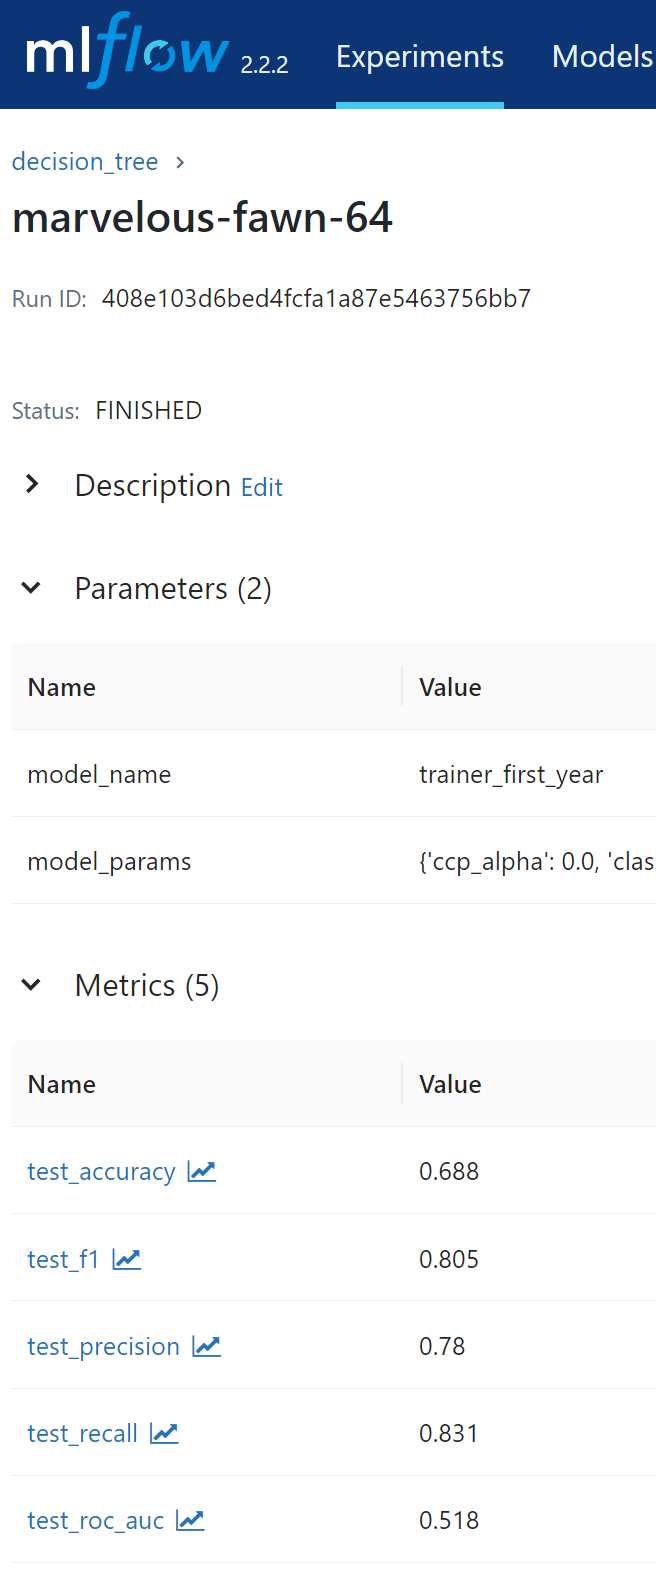

Let's set it as the production model

In [6]:
MLflowManager.set_model_stage(trainer_first_year.name, model_version=1, stage='production')

Now we can see how in the UI in the model section this model is set with the stage 'Production'

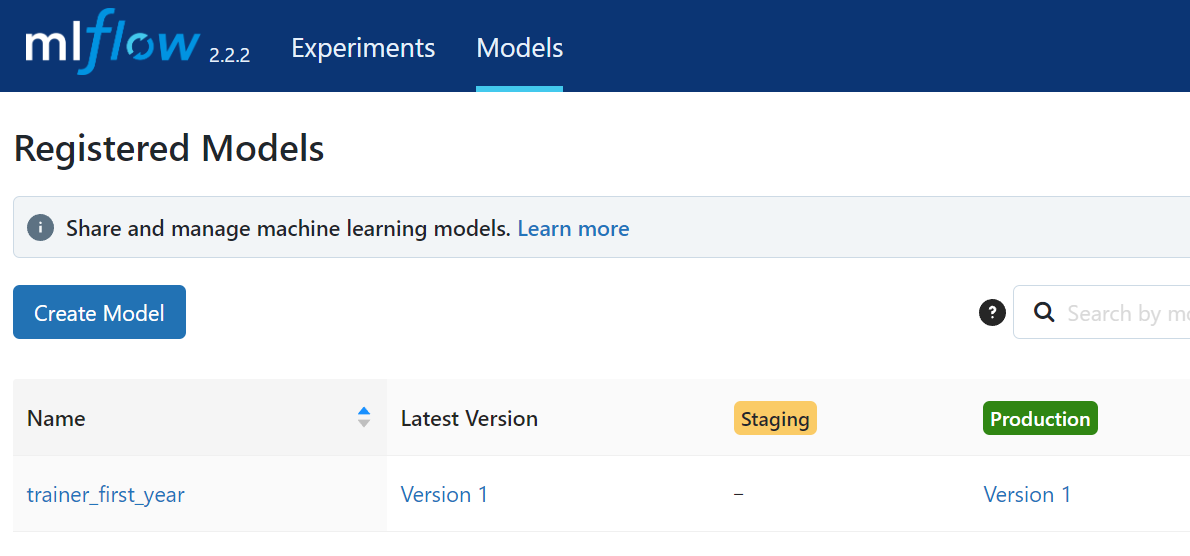

We can also load the model and make predictions

In [7]:
model = MLflowManager.load_model(trainer_first_year.name, '1', 'http://127.0.0.1:5000')
y_preds = model.predict(splitter.X_test)[:5]

Model trainer_first_year loaded from MLflow


So now we have trained a model after 1 year of data, as we mentioned we want to know track if this model is going to perform well on the new incoming data, in a real scenario we could track on daily basis if the input data is drifting and retrain a new model if necessary.

In this case as we already have all the data series, what we are going to do is analyze the drift and after every year rather than on a daily basis.

## 2.3 Second year of data

Imagine that a year has passed and we want to know if the data has changed during this time. Before retrain a new model we could check if the distribution of the input variables has changed

### 2.3.1 Input drift

There are many techniques to check if there is the X variable have drifted, but the idea basically is to check whether the distribution of a period t is equal to the one in period t+1. In this case we are going to use Kolmogorov-Smirnov test for numerical variables and Chi-square test for categorical variables.

There are many other tests and techniques, like train a [domain classifier](https://www.analyticsvidhya.com/blog/2021/10/mlops-and-the-importance-of-data-drift-detection/#:~:text=A%20Machine%20Learning,become%20computationally%20expensive.), to check if there is drift in the input variables, but for the sake of simplicity we are going to use these two. Please check out [this article](https://towardsdatascience.com/mlops-understanding-data-drift-69f9bf8a2e46) to dig deeper into this topic.

In [8]:
first_year_X,  first_year_y= splitter.x_y_filter_by_month(from_month=0, to_month=12)
second_year_X,  second_year_y= splitter.x_y_filter_by_month(from_month=12, to_month=24)


drift_detector = DriftDetector(
    name = 'drift_detector'
    , random_state=SEED
)

drifted_columns = drift_detector.univariate_input_drift(first_year_X, second_year_X)

In [9]:
print(f"Drifted columns: {drifted_columns}")

Drifted columns: [['Unnamed: 0', 'annual_inc', 'fico_range_high', 'installment', 'int_rate', 'revol_bal', 'revol_util', 'issue_d_month', 'issue_d_year', 'addr_state_CA', 'purpose_debt_consolidation', 'sub_grade_A5', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified']]


This only means that we need to retrain our model, but let's now check now if the target variable has changed

### 2.3.2 Target drift
As it's a categorical variable we are going to use the Chi-square test to check if the distribution of the target variable has changed.

In [10]:
p_value = DriftDetector.kolmogorow_smirnov_test(first_year_y, second_year_y)

if p_value < 0.05:
    print("Warning: target variable has drifted")

There is also drift in the target variable, so we need to retrain our model. Let's now check if there is concept drift.

### 2.3.3 Concept drift

There also many techniques also available but in this case I chose to just retrain a challenger model and compare it to our model in production. For simplicity and to test both models under the same conditions.



In [11]:
splitter.set_train_test_filtered(number_of_months=24)

trainer_second_year = ClassifierTrainer(
    name = 'trainer_second_year'
    , model_class = DecisionTreeClassifier()
    , random_state=SEED
    , splitter = splitter
    , objective_metric = 'roc_auc'
)

trainer_second_year.set_model_params(
    params = trainer_first_year.params
)

trainer_second_year.train()
trainer_second_year.predict(splitter.X_test)
trainer_second_year.evaluate(splitter.y_test)

mlflow_manager.make_run(run_name='second_year'
                          , experiment_name=experiment_name
                          , trainer=trainer_second_year
                          , log_model=True
                          )

Resampled data. New train size: 2945
Test and train attributes defined 0.3.
        Test size: 1375
        Train size: 2945
X_train shape: (2945, 142)
Model trainer_second_year trained
Model trainer_second_year has made the predictions


/Users/alejandroprietovelasco/miniconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/alejandroprietovelasco/miniconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). I

Model trainer_second_year logged in MLflow
Run completed


Created version '1' of model 'trainer_second_year'.


If now we start comparing the with the data of the third year both models and the performance is significantly better for the challenger model, it can be an indicative of concept drift.

In [12]:
start_period = 24
end_period = 36
step = 3
model_prod = MLflowManager.load_model(trainer_first_year.name, '1')


metrics = DriftDetector.predict_by_period(start_period = start_period
                  , end_period = end_period
                  , step = 3
                  , model_prod = model_prod
                  , model_challenger = trainer_second_year.model_class
                  , objective_metric = 'roc_auc'
                  , splitter = splitter)

Model trainer_first_year loaded from MLflow
Production model roc_auc: 0.581594381170992
Challenger model roc_auc: 0.5625336349957716

Production model roc_auc: 0.5335721300329868
Challenger model roc_auc: 0.5254589177347468

Production model roc_auc: 0.5269774576497266
Challenger model roc_auc: 0.540732959850607

Production model roc_auc: 0.5683306503052576
Challenger model roc_auc: 0.5388747987728943



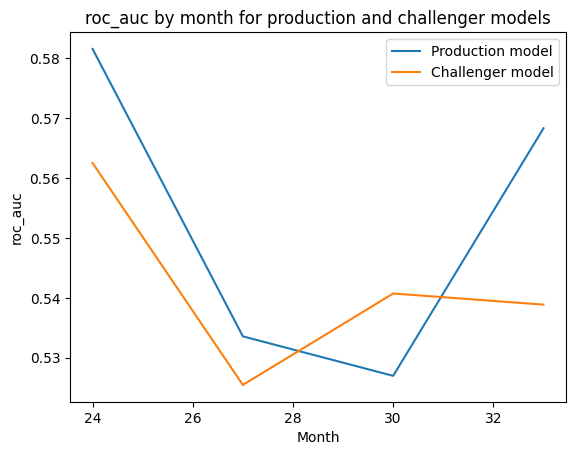

In [13]:
DriftDetector.plot_metric(metrics, 'roc_auc')

Let's now log all the metrics in mlflow for both models, and as the whole year has apssed let's see teh performance of both model with the whole year of data

In [14]:

model_in_production = MLflowManager.load_model(trainer_first_year.name, '1', 'http://127.0.0.1:5000')


third_year_X, third_year_y = splitter.x_y_filter_by_month(from_month=24, to_month=36)

y_preds_production = model_in_production.predict(third_year_X)
metrics_production = ClassifierTrainer.get_metrics(third_year_y, y_preds_production)

mlflow_manager.log_new_metrics(run_name='first_year'
                               , experiment_name=experiment_name
                               , metrics=metrics_production
                               , prefix='Third_year_'
                               )
               

trainer_second_year.predict(third_year_X)
results = trainer_second_year.get_metrics(third_year_y, trainer_second_year.y_pred)
mlflow_manager.log_new_metrics(run_name='second_year'
                               , experiment_name=experiment_name
                               , metrics=trainer_second_year.results
                               , prefix='Third_year_'
                               )
               

print(f"""ROC-AUC for first year model: {trainer_first_year.results['roc_auc']}
ROC-AUC for second year model: {trainer_second_year.results['roc_auc']}""")


Model trainer_first_year loaded from MLflow
first_year
Model trainer_second_year has made the predictions
second_year
ROC-AUC for first year model: 0.563153949215261
ROC-AUC for second year model: 0.5406893702602993


In this case the challenger model doesn't seems to do much better than the production one, so we can assume that there is no concept drift. But ideally we want to automate this, for the whole time series once we have a whole year of new data we are going to decide which model we keep, the challenguer or the production model.

## 2.4 Serving the model as an REST API

MLFlow comes with numerous integrations to [serve models to production](https://mlflow.org/docs/latest/models.html#built-in-deployment-tools) as python_functions in Saprk, Amazon sagemaker, or azure amongst many other custom flavors.

In this section we are going to serve the model created before as a REST API and make some requests to it. The step is to identify the path to the model we want to deploy, in this case is going to be the model in production.

In [15]:
model_name = 'trainer_first_year'
model_version = 1

model_path =MLflowManager.get_model_path(model_name, model_version)
print(model_path)


mlflow-artifacts:/1/d3985c6e6ab1449a9ba9e404cebbdbd5/artifacts/sklearn-model


After that in order to serve the model as a REST API we need to run the following code in a separate bash terminal

```bash
mlflow models serve -m mlartifacts<from the / before the version of the model auntil the end> -p 1234
```
example:
```bash
mlflow models serve -m mlartifacts/1/e9783bdc89cc4cda871a7fc3c18c4442/artifacts/sklearn-model/ -p 1234
```

The argument -p is the port where the model will be listening, it can be any other port.

Now we can make request to the model at 'http://127.0.0.1:1234/invocations'.

We could use a curl request in bash like

```bash
curl -X POST -H "Content-Type:application/json" --data '{"dataframe_split": {"columns":<LIST WITH COLUMNS> ,"index":<LIST WITH INDEX>,"data":[<LIST WITH DATA>]}}' http://127.0.0.1:1234/invocations
```

In [18]:
!curl -X POST -H "Content-Type:application/json" --data '{"dataframe_split": {"columns": ["Unnamed: 0", "annual_inc", "fico_range_high", "installment", "int_rate", "num_bc_sats", "num_bc_tl", "num_il_tl", "pub_rec", "pub_rec_bankruptcies", "revol_bal", "revol_util", "tot_coll_amt", "tot_cur_bal", "issue_d_month", "issue_d_year", "addr_state_AK", "addr_state_AL", "addr_state_AR", "addr_state_AZ", "addr_state_CA", "addr_state_CO", "addr_state_CT", "addr_state_DC", "addr_state_DE", "addr_state_FL", "addr_state_GA", "addr_state_HI", "addr_state_IA", "addr_state_ID", "addr_state_IL", "addr_state_IN", "addr_state_KS", "addr_state_KY", "addr_state_LA", "addr_state_MA", "addr_state_MD", "addr_state_ME", "addr_state_MI", "addr_state_MN", "addr_state_MO", "addr_state_MS", "addr_state_MT", "addr_state_Missing", "addr_state_NC", "addr_state_ND", "addr_state_NE", "addr_state_NH", "addr_state_NJ", "addr_state_NM", "addr_state_NV", "addr_state_NY", "addr_state_OH", "addr_state_OK", "addr_state_OR", "addr_state_PA", "addr_state_RI", "addr_state_SC", "addr_state_SD", "addr_state_TN", "addr_state_TX", "addr_state_UT", "addr_state_VA", "addr_state_VT", "addr_state_WA", "addr_state_WI", "addr_state_WV", "addr_state_WY", "application_type_Individual", "application_type_Joint App", "application_type_Missing", "home_ownership_ANY", "home_ownership_MORTGAGE", "home_ownership_Missing", "home_ownership_NONE", "home_ownership_OTHER", "home_ownership_OWN", "home_ownership_RENT", "initial_list_status_Missing", "initial_list_status_f", "initial_list_status_w", "purpose_Missing", "purpose_car", "purpose_credit_card", "purpose_debt_consolidation", "purpose_educational", "purpose_home_improvement", "purpose_house", "purpose_major_purchase", "purpose_medical", "purpose_moving", "purpose_other", "purpose_renewable_energy", "purpose_small_business", "purpose_vacation", "purpose_wedding", "sub_grade_A1", "sub_grade_A2", "sub_grade_A3", "sub_grade_A4", "sub_grade_A5", "sub_grade_B1", "sub_grade_B2", "sub_grade_B3", "sub_grade_B4", "sub_grade_B5", "sub_grade_C1", "sub_grade_C2", "sub_grade_C3", "sub_grade_C4", "sub_grade_C5", "sub_grade_D1", "sub_grade_D2", "sub_grade_D3", "sub_grade_D4", "sub_grade_D5", "sub_grade_E1", "sub_grade_E2", "sub_grade_E3", "sub_grade_E4", "sub_grade_E5", "sub_grade_F1", "sub_grade_F2", "sub_grade_F3", "sub_grade_F4", "sub_grade_F5", "sub_grade_G1", "sub_grade_G2", "sub_grade_G3", "sub_grade_G4", "sub_grade_G5", "sub_grade_Missing", "term_ 36 months", "term_ 60 months", "term_Missing", "verification_status_Missing", "verification_status_Not Verified", "verification_status_Source Verified", "verification_status_Verified", "disbursement_method_Cash", "disbursement_method_DirectPay", "disbursement_method_Missing"], "data": [[0.794381724659692, -0.2040211371019774, -0.5630931346199877, -0.3816865767920636, 0.2746584584758322, -0.2513024718069518, -0.1520286048968397, -0.3222738697045718, -0.3462218943757582, -0.3514658182281756, 0.1606064608203858, 1.4436417534923296, -0.0268923559242969, -0.3865228964381555, -0.5140149024602513, -3.825549366429596, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]]}}' http://127.0.0.1:1234/invocations

{"predictions": [0]}

Alternatevely we can make a request with the following code

In [19]:
import requests
import json

url = 'http://127.0.0.1:1234/invocations'


def make_api_request(dataframe, url):
    headers = {'Content-Type': 'application/json'}

    # Extract the column names and data from the dataframe
    columns = list(dataframe.columns)
    data = dataframe.values.tolist()

    payload = {
        "dataframe_split": {
            "columns": columns,
            "data": data
        }
    }

    response = requests.post(url, headers=headers, data=json.dumps(payload))
    return response.json()

make_api_request(splitter.X_test.head(), url)

{'predictions': [0, 1, 1, 1, 1]}

Obviously this is just an example and the deployment can be much more complex, there are speacialzed toold such as [BentoML](https://www.bentoml.com/) that specialize in this.

## 2.5 Running the whole timeseries

Finally we can automate the previous steps fo rthe whole time series, automating the input drift detection, retraining and selection of challeguer model in case that is needed.

We will train 1 model per year and track them every trimester, comparing it to the challeguer model. If after a yer of data the challenger model is better we will set this model as the production one.

In [20]:
utils.set_child_directory_as_working_directory('src')
!python modelling.py -n whole_series_decission_tree -p True

-------------- Executing splitter --------------
Data loaded from ./data/fe_data.csv
Dates data loaded from ./data/dates_data.csv
Test and train attributes defined 0.3.
        Test size: 678211
        Train size: 1582490
--------------- splitter finished ---------------
[------------------ Iteration 1 started ------------------
Training model for 2010-06-01 00:00:00 to 2011-06-01 00:00:00
Resampled data. New train size: 1190
Test and train attributes defined 0.3.
        Test size: 597
        Train size: 1190
X_train shape: (1190, 142)
Model model_1_year trained
Model model_1_year has made the predictions
2023/06/24 14:58:01 INFO mlflow.tracking.fluent: Experiment with name 'whole_series_decission_tree' does not exist. Creating a new experiment.
/Users/alejandroprietovelasco/miniconda3/envs/tfm_env/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If y

## 2.6 Comparing first and last model

To finalize this exercise we are going to compare how the first model would perform comprared to our latest model on the last year of data. The objective is to see what would have happened if we didn't retrained the model.

In this run the model 10 was the last model go into production, but due to the random natura

Model model_1_year loaded from MLflow
Model model_10_year loaded from MLflow


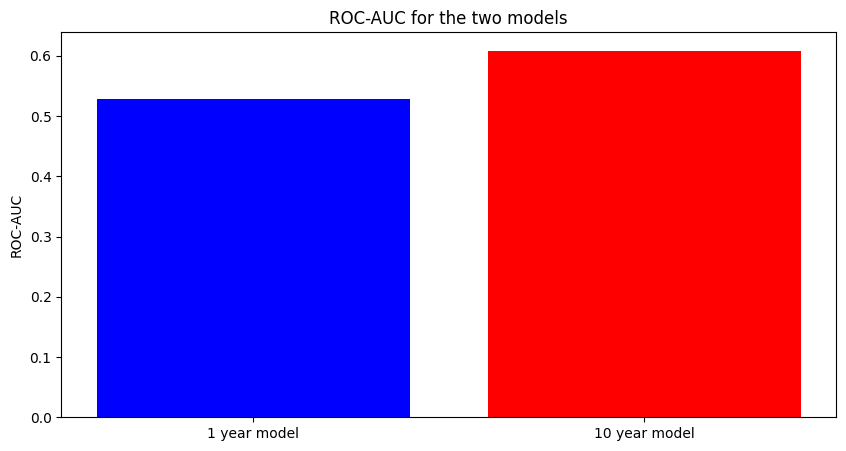

In [21]:
# Loading models
model_1_year = MLflowManager.load_model('model_1_year', '1', 'http://127.0.0.1:5000')
model_10_year = MLflowManager.load_model('model_10_year', '1', 'http://127.0.0.1:5000')

# Setting last year of data as test data
#utils.set_parent_directory_as_working_directory()
last_month = len(splitter.dates_data.finished_d.sort_values().unique())
last_year_X,  last_year_y = splitter.x_y_filter_by_month(from_month=last_month - 12, to_month=last_month )

# Predicting and evaluating
y_preds_model_1_year = model_1_year.predict(last_year_X)
metrics_model_1_year = ClassifierTrainer.get_metrics(last_year_y, y_preds_model_1_year )

y_preds_model_10_year = model_10_year.predict(last_year_X)
metrics_model_10_year = ClassifierTrainer.get_metrics(last_year_y, y_preds_model_10_year )

# Plotting roc-auc
roc_auc_model = [metrics_model_1_year['roc_auc'], metrics_model_10_year['roc_auc']]

# Plotting the ROC-AUC for the two models
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(['1 year model', '10 year model'], roc_auc_model, color=['blue', 'red'])
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC for the two models')
plt.show()

In [22]:
roc_auc_model 

[0.5276272774258743, 0.6085492192326521]

We can see how different both model's perform differently qith the last year of data, being the model from the first almost as bad as predictor that do random guesses and the model of the 10th year being able to score above 0,6 in ROC AUC which is not very good but at least better that a random predictor.